In [9]:
'''
purpose 
    to use 2 recognition runs in the current day and the saved model trained earlier 
        to get the functionalTemplateTR to align the feedback dicom to
        to align the selected functionalTemplateTR 
        register this day2 functional template volume with day1 functional template 
    to generate the metric Gaussian parameter and curve
'''

import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti

from rtCommon.cfg_loading import mkdir,cfg_loading
cfg = cfg_loading('sub001.ses2.toml')

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')






# import and set up environment
import sys
from subprocess import call
import nibabel as nib
import pydicom as dicom
import numpy as np
import time
import os
from glob import glob
import shutil
import pandas as pd
# from import convertDicomFileToNifti
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti, readDicomFromFile
from rtCommon.cfg_loading import mkdir,cfg_loading

'''
purpose: 
    prepare data for the model training code.
steps:
    convert all dicom files into nii files in the temp dir. 
    find the middle volume of the run1 as the template volume, convert this to the previous template volume space and save the converted file as today's functional template (templateFunctionalVolume)
    align every other functional volume with templateFunctionalVolume (3dvolreg)
'''

# convert all dicom files into nii files in the temp dir. 
tmp_dir=f"{cfg.tmp_folder}{time.time()}/" ; mkdir(tmp_dir)
dicomFiles=glob(f"{cfg.dicom_dir}/*.dcm") ; dicomFiles.sort()
for curr_dicom in dicomFiles:
    dicomImg = readDicomFromFile(curr_dicom) # read dicom file
    convertDicomImgToNifti(dicomImg, dicomFilename=f"{tmp_dir}/{curr_dicom.split('/')[-1]}") #convert dicom to nii    
    # os.remove(f"{tmp_dir}/{curr_dicom.split('/')[-1]}") # remove temp dcm file

# find the middle volume of the run1 as the template volume
# here you are assuming that the first run is a good run
tmp=glob(f"{tmp_dir}/001_000002*.nii") ; tmp.sort()
call(f"cp {tmp[int(len(tmp)/2)]} {cfg.templateFunctionalVolume}", shell=True)

# convert cfg.templateFunctionalVolume to the previous template volume space 
call(f"flirt -ref {cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/templateFunctionalVolume.nii \
    -in {cfg.templateFunctionalVolume} \
    -out {cfg.recognition_dir}/templateFunctionalVolume_converted.nii",shell=True)

# save the converted file as today's functional template (templateFunctionalVolume) 
call(f"mv {cfg.recognition_dir}/templateFunctionalVolume_converted.nii \
    {cfg.templateFunctionalVolume}",shell=True)

# align every other functional volume with templateFunctionalVolume (3dvolreg)
allTRs=glob(f"{tmp_dir}/001_00000[2,3]*.nii") ; allTRs.sort()


# select a list of run IDs based on the runRecording.csv, actualRuns would be [1,2] is the 1st and the 3rd runs are recognition runs.
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])])
for curr_run in actualRuns:
    outputFileNames=[]
    runTRs=glob(f"{tmp_dir}/001_{str(curr_run).zfill(6)}_*.nii") ; runTRs.sort()
    for curr_TR in runTRs:
        command = f"3dvolreg \
            -base {cfg.templateFunctionalVolume} \
            -prefix  {curr_TR[0:-4]}_aligned.nii \
            {curr_TR}"
        call(command,shell=True)
        outputFileNames.append(f"{curr_TR[0:-4]}_aligned.nii")
    files=''
    for f in outputFileNames:
        files=files+' '+f
    command=f"fslmerge -t {cfg.recognition_dir}run{curr_run}.nii {files}"
    print('running',command)
    call(command, shell=True)

# remove the tmp folder
shutil.rmtree(tmp_dir)

'''
for each run, 
    load behavior data 
    push the behavior data back for 2 TRs
    save the brain TRs with images
    save the behavior data
'''

def behaviorDataLoading(cfg,curr_run):
    '''
    extract the labels which is selected by the subject and coresponding TR and time
    check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
    '''
    behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{curr_run}.csv")

    # the item(imcode) colume of the data represent each image in the following correspondence
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # When the imcode code is "A", the correct response should be '1', "B" should be '2'
    correctResponseDict={
    'A': 1,
    'B': 2,
    'C': 1,
    'D': 2}

    # extract the labels which is selected by the subject and coresponding TR and time
    behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item']] # the TR, the real time it was presented, 
    behav_data=behav_data.dropna(subset=['Item'])

    # check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
    isCorrect=[]
    for curr_trial in range(behav_data.shape[0]):
        isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])

    behav_data['isCorrect']=isCorrect # merge the isCorrect clumne with the data dataframe
    behav_data['subj']=[cfg.subjectName for i in range(len(behav_data))]
    behav_data['run_num']=[int(curr_run) for i in range(len(behav_data))]
    behav_data=behav_data[behav_data['isCorrect']] # discard the trials where the subject made wrong selection
    return behav_data


for curr_run_behav,curr_run in enumerate(actualRuns):
    # load behavior data
    behav_data = behaviorDataLoading(cfg,curr_run_behav+1)

    # brain data is first aligned by pushed back 2TR(4s)
    brain_data = nib.load(f"{cfg.recognition_dir}run{curr_run}.nii.gz").get_data() ; brain_data=np.transpose(brain_data,(3,0,1,2))
    Brain_TR=np.arange(brain_data.shape[0])
    Brain_TR = Brain_TR+2

    # select volumes of brain_data by counting which TR is left in behav_data
    Brain_TR=Brain_TR[list(behav_data['TR'])] # original TR begin with 0
    if Brain_TR[-1]>=brain_data.shape[0]: # when the brain data is not as long as the behavior data, delete the last row
        Brain_TR = Brain_TR[:-1]
        behav_data = behav_data.drop([behav_data.iloc[-1].TR])
    brain_data=brain_data[Brain_TR]
    np.save(f"{cfg.recognition_dir}brain_run{curr_run}.npy", brain_data)
    # save the behavior data
    behav_data.to_csv(f"{cfg.recognition_dir}behav_run{curr_run}.csv")


running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run2.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000002_000008_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.118

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run3.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.1187592/001_000003_000008_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1610949733.118

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [26]:
'''
purpose:
    get the morphing target function
steps:
    load train clf
    load brain data and behavior data
    get the morphing target function
        evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
        evidence_ceil  is A evidence in AC and AD classifier
'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

'''
if you read runRecording for current session and found that there are only 4 runs in the current session, 
you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
'''
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]


objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.chosenMask}").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe

# evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)


def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    return np.asarray(Evidence)

A_ID = (META['label']=='bed')
X = FEAT[A_ID]

Y = ['table'] * X.shape[0]
CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf should be the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
CD_C_evidence = classifierEvidence(CD_clf,X,Y)
evidence_floor = np.mean(CD_C_evidence)
print(f"evidence_floor={evidence_floor}")

# evidence_ceil  is A evidence in AC and AD classifier
Y = ['bed'] * X.shape[0]
AC_clf=joblib.load(cfg.usingModel_dir +'bedbench_bedtable.joblib') # These 4 clf should be the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
AC_A_evidence = classifierEvidence(AC_clf,X,Y)
evidence_ceil1 = AC_A_evidence
# print(f"evidence_ceil1={evidence_ceil1}")

Y = ['bed'] * X.shape[0]
AD_clf=joblib.load(cfg.usingModel_dir +'bedchair_bedbench.joblib') # These 4 clf should be the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
AD_A_evidence = classifierEvidence(AD_clf,X,Y)
evidence_ceil2 = AD_A_evidence
# print(f"evidence_ceil2={evidence_ceil2}")

evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
print(f"evidence_ceil={evidence_ceil}")

evidence_floor=-4.707058647848117
evidence_ceil=2.350234615141938


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


evidence_floor=-4.707058647848117
evidence_ceil=2.350234615141938


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


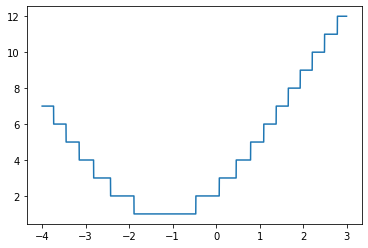

In [43]:
# from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading,recognition_preprocess_2run,morphingTarget
def morphingTarget(cfg):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression
    from tqdm import tqdm


    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
    else:
        main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

    working_dir=main_dir
    os.chdir(working_dir)

    '''
    if you read runRecording for current session and found that there are only 4 runs in the current session, 
    you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
    '''
    runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

    objects = ['bed', 'bench', 'chair', 'table']

    for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
        t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
        mask = nib.load(f"{cfg.chosenMask}").get_data()
        t = t[:,mask==1]
        brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

        t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
        behav_data=t if ii==0 else pd.concat([behav_data,t])

    FEAT=brain_data.reshape(brain_data.shape[0],-1)
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    label=[]
    for curr_trial in range(META.shape[0]):
        label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    META['label']=label # merge the label column with the data dataframe

    # evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
    

    def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
        # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
        targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
        Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]

    Y = ['table'] * X.shape[0]
    CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"evidence_floor={evidence_floor}")

    # evidence_ceil  is A evidence in AC and AD classifier
    Y = ['bed'] * X.shape[0]
    AC_clf=joblib.load(cfg.usingModel_dir +'bedbench_bedtable.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence

    Y = ['bed'] * X.shape[0]
    AD_clf=joblib.load(cfg.usingModel_dir +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence

    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")

    return evidence_floor, evidence_ceil

floor, ceil = morphingTarget(cfg)

def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))))

mu = (floor+ceil)/2
sig = (ceil-floor)/2.3548

x=np.arange(-4,3,0.001)
y=[gaussian(i, mu, sig) for i in x]
plt.plot(x,y)

In [55]:
np.save(f"{cfg.feedback_dir}morphingTarget",[mu,sig])

[-1.1784120163530896, 2.996982020974204]

In [4]:
'''
purpose 
    to use 2 recognition runs in the current day and the saved model trained earlier 
        to get the functionalTemplateTR to align the feedback dicom to
        to align the selected functionalTemplateTR 
        register this day2 functional template volume with day1 functional template 
    to generate the metric Gaussian parameter and curve
'''

import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti

# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses2.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
cfg = cfg_loading("sub001.ses2.toml")

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading,recognition_preprocess_2run,morphingTarget




'''
convert all dicom files into nii files in the temp dir. 
find the middle volume of the run1 as the template volume
align every other functional volume with templateFunctionalVolume (3dvolreg)
load behavior data and align with brain data
'''
run_asTemplate=2 # which run in the realtime folder to select the middle volume as the template volume
recognition_preprocess_2run(cfg,run_asTemplate)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run2.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000002_000008_aligned.n

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run3.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.9213703/001_000003_000008_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611311854.921

In [6]:
import pandas as pd
'''
purpose: 
    prepare the data for 2 recognition runs     (to later(not in this function) get the morphing target function)
    find the functional template image for current session
steps:
    convert all dicom files into nii files in the temp dir. 
    find the middle volume of the run1 as the template volume, convert this to the previous template volume space and save the converted file as today's functional template (templateFunctionalVolume)
    align every other functional volume with templateFunctionalVolume (3dvolreg)
'''
from shutil import copyfile
from rtCommon.imageHandling import convertDicomFileToNifti
# convert all dicom files into nii files in the temp dir. 
tmp_dir=f"{cfg.tmp_folder}{time.time()}/" ; mkdir(tmp_dir)
dicomFiles=glob(f"{cfg.dicom_dir}/*.dcm") ; dicomFiles.sort()
for curr_dicom in dicomFiles:
    # dicomImg = readDicomFromFile(curr_dicom) # read dicom file
    dicomFilename=f"{tmp_dir}{curr_dicom.split('/')[-1]}"
    copyfile(curr_dicom,dicomFilename)
    niftiFilename = dicomFilename[:-4]+'.nii'
    convertDicomFileToNifti(dicomFilename, niftiFilename)
    # convertDicomImgToNifti(dicomImg, dicomFilename=f"{tmp_dir}{curr_dicom.split('/')[-1]}") #convert dicom to nii    
    # os.remove(f"{tmp_dir}/{curr_dicom.split('/')[-1]}") # remove temp dcm file

# find the middle volume of the run1 as the template volume
# here you are assuming that the first run is a good run
run_asTemplate=str(run_asTemplate).zfill(6)
tmp=glob(f"{tmp_dir}001_{run_asTemplate}*.nii") ; tmp.sort()
# call(f"cp {tmp[int(len(tmp)/2)]} {cfg.recognition_dir}t.nii", shell=True)

# convert cfg.templateFunctionalVolume to the previous template volume space 
call(f"flirt -ref {cfg.templateFunctionalVolume} \
    -in {tmp[int(len(tmp)/2)]} \
    -out {cfg.templateFunctionalVolume_converted}",shell=True) 

# align every other functional volume with templateFunctionalVolume (3dvolreg)
allTRs=glob(f"{tmp_dir}001_*.nii") ; allTRs.sort()

# select a list of run IDs based on the runRecording.csv, actualRuns would be [1,2] is the 1st and the 3rd runs are recognition runs.
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])])
for curr_run in actualRuns:
    outputFileNames=[]
    runTRs=glob(f"{tmp_dir}001_{str(curr_run).zfill(6)}_*.nii") ; runTRs.sort()
    for curr_TR in runTRs:
        command = f"3dvolreg \
            -base {cfg.templateFunctionalVolume_converted} \
            -prefix  {curr_TR[0:-4]}_aligned.nii \
            {curr_TR}"
        call(command,shell=True)
        outputFileNames.append(f"{curr_TR[0:-4]}_aligned.nii")
    files=''
    for f in outputFileNames:
        files=files+' '+f
    command=f"fslmerge -t {cfg.recognition_dir}run{curr_run}.nii {files}"
    print('running',command)
    call(command, shell=True)

# remove the tmp folder
shutil.rmtree(tmp_dir)

'''
for each run, 
    load behavior data 
    push the behavior data back for 2 TRs
    save the brain TRs with images
    save the behavior data
'''

for curr_run_behav,curr_run in enumerate(actualRuns):
    # load behavior data
    behav_data = behaviorDataLoading(cfg,curr_run_behav+1)

    # brain data is first aligned by pushed back 2TR(4s)
    brain_data = nib.load(f"{cfg.recognition_dir}run{curr_run}.nii.gz").get_data() ; brain_data=np.transpose(brain_data,(3,0,1,2))
    Brain_TR=np.arange(brain_data.shape[0])
    Brain_TR = Brain_TR+2

    # select volumes of brain_data by counting which TR is left in behav_data
    Brain_TR=Brain_TR[list(behav_data['TR'])] # original TR begin with 0
    if Brain_TR[-1]>=brain_data.shape[0]: # when the brain data is not as long as the behavior data, delete the last row
        Brain_TR = Brain_TR[:-1]
        behav_data = behav_data.drop([behav_data.iloc[-1].TR])
    brain_data=brain_data[Brain_TR]
    np.save(f"{cfg.recognition_dir}brain_run{curr_run}.npy", brain_data)
    # save the behavior data
    behav_data.to_csv(f"{cfg.recognition_dir}behav_run{curr_run}.csv")


running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run2.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000002_000008_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.018

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses2/recognition/run3.nii  /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000001_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000002_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000003_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000004_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000005_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000006_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000007_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.0182986/001_000003_000008_aligned.nii /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611312114.018

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [31]:
!ls /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611310141.8247683/


001_000001_000001.dcm  test


In [11]:
f"{tmp_dir}{curr_dicom.split('/')[-1]}"

'/gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611303802.8345847/001_000001_000001.dcm'

In [16]:
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.chosenMask}").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

print(brain_data.shape)
print(behav_data.shape)

(94, 2482)
(94, 8)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(94, 2482)

In [17]:
behav_data

,Unnamed: 0,TR,image_on,Resp,Item,isCorrect,subj,run_num
0,3,3,5.999537,2.0,D,True,sub001,1
1,5,5,9.999614,2.0,B,True,sub001,1
2,8,8,15.999709,1.0,A,True,sub001,1
3,12,12,23.999743,1.0,C,True,sub001,1
4,15,15,29.999806,2.0,D,True,sub001,1
...,...,...,...,...,...,...,...,...
42,129,129,258.010215,2.0,D,True,sub001,2
43,132,132,264.010246,2.0,B,True,sub001,2
44,136,136,272.010324,2.0,D,True,sub001,2
45,139,139,278.010414,1.0,A,True,sub001,2


In [18]:
'''
purpose:
    get the morphing target function
steps:
    load train clf
    load brain data and behavior data
    get the morphing target function
        evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
        evidence_ceil  is A evidence in AC and AD classifier
'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.chosenMask}").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe

# evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)

def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    return np.asarray(Evidence)

A_ID = (META['label']=='bed')
X = FEAT[A_ID]

Y = ['table'] * X.shape[0]
CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
CD_C_evidence = classifierEvidence(CD_clf,X,Y)
evidence_floor = np.mean(CD_C_evidence)
print(f"evidence_floor={evidence_floor}")

# evidence_ceil  is A evidence in AC and AD classifier
Y = ['bed'] * X.shape[0]
AC_clf=joblib.load(cfg.usingModel_dir +'bedbench_bedtable.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
AC_A_evidence = classifierEvidence(AC_clf,X,Y)
evidence_ceil1 = AC_A_evidence

Y = ['bed'] * X.shape[0]
AD_clf=joblib.load(cfg.usingModel_dir +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
AD_A_evidence = classifierEvidence(AD_clf,X,Y)
evidence_ceil2 = AD_A_evidence

evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
print(f"evidence_ceil={evidence_ceil}")


evidence_floor=18.574122173548336
evidence_ceil=-10.104527931140426


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [22]:
tmp_dir=f"{cfg.tmp_folder}{time.time()}/" ; mkdir(tmp_dir)

In [23]:

from rtCommon.imageHandling import readDicomFromBuffer
dicomFilename="/gpfs/milgram/project/realtime/DICOM/20210114.rtSynth_sub001.rtSynth_sub001//001_000001_000001.dcm"

# dicomFilename=f"{tmp_dir}{curr_dicom.split('/')[-1]}"
copyfile(dicomFilename,tmp_dir+"001_000001_000001.dcm")
dicomFilename=tmp_dir+"001_000001_000001.dcm"

niftiFilename = dicomFilename[:-4]+'.nii'
convertDicomFileToNifti(dicomFilename, niftiFilename)
# dicomImg = readDicomFromBuffer(dcm)
# # check that pixel array is complete
# dicomImg.convert_pixel_data()

In [26]:
a=nib.load(niftiFilename)
print(a)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (64, 64, 36)
affine: 
[[-2.99905014e+00  9.94529948e-03  9.35408548e-02  9.45031433e+01]
 [ 4.78221197e-03  2.99290800e+00 -2.57629186e-01 -8.19153595e+01]
 [ 7.53390267e-02  2.05918789e-01  3.73997045e+00 -7.23668442e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [ 3 64 64 36  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.    3.    3.    3.75  2.    0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating increasing 2
xyzt_units      : 10
cal_max         : 0.0
cal_mi

In [28]:
nib.save(a, tmp_dir+"test.nii")  
tmp_dir

'/gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611337888.3280215/'

In [30]:
!ls /gpfs/milgram/scratch60/turk-browne/kp578/rtcloud_rt/1611337888.3280215/

001_000001_000001.dcm  001_000001_000001.nii  test.nii


In [32]:
"/gpfs/milgram/project/realtime/DICOM/20210114.rtSynth_sub001.rtSynth_sub001//001_000001_000009.dcm".split("/")[-1].split(".")[0]

'001_000001_000009'

In [35]:
mask=nib.load(cfg.chosenMask).get_data()


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
